In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
import numpy as np
from sympy import Matrix
import re

def parse_op(op_str):
    """Parse a symmetry operation string like 'x+1/2,-y,z+1/4'."""
    parts = op_str.split(',')
    xyz = parts
    rot = np.zeros((3, 3), dtype=int)
    trans = np.zeros(3)
    basis = {'x': [1, 0, 0], 'y': [0, 1, 0], 'z': [0, 0, 1]}
    for i, expr in enumerate(xyz):
        for var, vec in basis.items():
            if var in expr:
                sign = -1 if '-' + var in expr else 1
                rot[i] += sign * np.array(vec)
        match = re.search(r'([+-]?\d+)/(\d+)', expr)
        if match:
            trans[i] = float(match.group(1)) / float(match.group(2))
    return rot, trans

def parse_atomic_pos(atomic_pos_str):

    return 

def read_cif_file(filename):
    # The CIF file format I'm using is the one you get from materialsproject when you download the "symmetrized" option.
    symmetry_operations_started=False
    symmetry_operations=[]
    atomic_positions_started=False
    atomic_positions=[]
    with open(filename) as f:
        for line in f:
            if not symmetry_operations_started and not atomic_positions_started:
                if '_symmetry_equiv_pos_as_xyz' in line:
                    print('found symmetry operations block in CIF!')
                    symmetry_operations_started=True
                if '_atom_site_occupancy' in line:
                    print('found atomic positions block in CIF!')
                    atomic_positions_started=True
            else:
                if symmetry_operations_started:
                    if 'loop' in line:
                        symmetry_operations_started=False
                    else:
                        line="".join(line.split())
                        sym_ops=line.split("'")[1]
                        symmetry_operations.append(parse_op(sym_ops))
                elif atomic_positions_started:
                    if line == '\n':
                        atomic_positions_started=False
                    else:
                        atom_pos=list(filter(None,line.split('\n')[0].split(' ')))
                        atomic_positions=parse_atomic_pos(atom_pos)
    return symmetry_operations, atomic_positions

def get_k_sphere(n_points):
    # Get an array of n_points on a sphere of radius 1
    # shape (n_points)
    n_theta=int(np.sqrt(n_points)*np.sqrt(2))
    n_phi=int(n_points/n_theta)
    thetas = np.linspace(0, 2*np.pi, n_theta)
    phis = np.linspace(0, np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(thetas, phis)
    xgrid=np.sin(phi_grid) * np.cos(theta_grid)
    ygrid=np.sin(phi_grid) * np.sin(theta_grid)
    zgrid = np.cos(phi_grid)
    
    points = np.stack([xgrid, ygrid, zgrid], axis=-1).reshape(-1, 3)  # Shape (N, 3)
    return points,xgrid,ygrid,zgrid,theta_grid,phi_grid

def make_symmetry_operation(rotation,translation,time_reversal):
    def sym_op(p):
        return rotation*time_reversal @ p
    return sym_op

def minimal_invariant_distance(k_transformed, k):
    delta = k_transformed - k
    # Check all possible G vectors within [-1,0,1] in each dimension to find minimal distance
    min_dist = np.inf
    for nx in [-1, 0, 1]:
        for ny in [-1, 0, 1]:
            for nz in [-1, 0, 1]:
                G = np.array([nx, ny, nz])
                dist = np.linalg.norm(delta - G)
                if dist < min_dist:
                    min_dist = dist
    min_dist= np.linalg.norm(delta)
    return min_dist
    
def score_invariantness_points(k_points,symmetry_operations):
    distances_from_invariant=[]

    for k_point in k_points:
        distance_from_invariant=np.inf
        for symmetry_operation in symmetry_operations.values():
            k_point_symmetry=symmetry_operation(k_point)
            if (dist:=minimal_invariant_distance(k_point_symmetry,k_point))<distance_from_invariant:
                distance_from_invariant=dist
        distances_from_invariant.append(distance_from_invariant)
    return np.array(distances_from_invariant)

def plot_plane_cut(xs, ys, zs, hkl, thickness=0.1):
    # Flatten points
    x = xs.ravel()
    y = ys.ravel()
    z = zs.ravel()
    points = np.stack([x, y, z], axis=1)

    # Normalize normal vector
    normal = np.array(hkl, dtype=float)
    normal /= np.linalg.norm(normal)

    # Project points onto plane
    dist = points @ normal
    mask = np.abs(dist) < thickness
    cut_points = points[mask]

    # Define 2D basis vectors in the plane
    if not np.allclose(normal, [1, 0, 0]):
        ref = np.array([1, 0, 0])
    else:
        ref = np.array([0, 1, 0])
    u = np.cross(normal, ref)
    u /= np.linalg.norm(u)
    v = np.cross(normal, u)

    # Project to 2D
    u_coords = cut_points @ u
    v_coords = cut_points @ v

    # Plot
    plt.figure(figsize=(5, 5))
    plt.scatter(u_coords, v_coords, s=1, color='black')
    plt.gca().set_aspect('equal')
    plt.title(f"Plane cut normal to ({hkl[0]} {hkl[1]} {hkl[2]})")
    plt.xlabel("u")
    plt.ylabel("v")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid(True)
    plt.show()

In [18]:
read_cif_file('./LaFeO3_mp-22590_symmetrized.cif')

found symmetry operations block in CIF!
found atomic positions block in CIF!
['La', 'La0', '4', '0.03825900', '0.25000000', '0.99061900', '1']
['Fe', 'Fe1', '4', '0.00000000', '0.00000000', '0.50000000', '1']
['O', 'O2', '8', '0.21202500', '0.54627500', '0.21259400', '1']
['O', 'O3', '4', '0.02173500', '0.75000000', '0.58612000', '1']


([(array([[1, 0, 0],
          [0, 1, 0],
          [0, 0, 1]]),
   array([0., 0., 0.])),
  (array([[-1,  0,  0],
          [ 0, -1,  0],
          [ 0,  0, -1]]),
   array([0., 0., 0.])),
  (array([[-1,  0,  0],
          [ 0, -1,  0],
          [ 0,  0,  1]]),
   array([0.5, 0. , 0.5])),
  (array([[ 1,  0,  0],
          [ 0,  1,  0],
          [ 0,  0, -1]]),
   array([0.5, 0. , 0.5])),
  (array([[ 1,  0,  0],
          [ 0, -1,  0],
          [ 0,  0, -1]]),
   array([0.5, 0.5, 0.5])),
  (array([[-1,  0,  0],
          [ 0,  1,  0],
          [ 0,  0,  1]]),
   array([0.5, 0.5, 0.5])),
  (array([[-1,  0,  0],
          [ 0,  1,  0],
          [ 0,  0, -1]]),
   array([0. , 0.5, 0. ])),
  (array([[ 1,  0,  0],
          [ 0, -1,  0],
          [ 0,  0,  1]]),
   array([0. , 0.5, 0. ]))],
 {})

In [155]:
d=read_mcif_file('./0.607_RuO2.mcif')
symmetry_operations_antiunitary={}
for i in range(len(d)):
    op=d[i]
    if op[2]<0:
        print(op)
        symmetry_operations_antiunitary[str(i)]=(make_symmetry_operation(*op))

found generator operations block!
found centering operations block!
(array([[ 0, -1,  0],
       [ 1,  0,  0],
       [ 0,  0,  1]]), array([0.5, 0.5, 0.5]), -1)
(array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]]), array([0.5, 0.5, 0.5]), -1)
(array([[ 0,  1,  0],
       [ 1,  0,  0],
       [ 0,  0, -1]]), array([0., 0., 0.]), -1)
(array([[ 0, -1,  0],
       [-1,  0,  0],
       [ 0,  0, -1]]), array([0., 0., 0.]), -1)
(array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0, -1]]), array([0.5, 0.5, 0.5]), -1)
(array([[ 0, -1,  0],
       [ 1,  0,  0],
       [ 0,  0, -1]]), array([0.5, 0.5, 0.5]), -1)
(array([[ 0, -1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]]), array([0., 0., 0.]), -1)
(array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]]), array([0., 0., 0.]), -1)


In [149]:

points,xgrid,ygrid,zgrid,theta_grid,phi_grid=get_k_sphere(10000)

# All antiunitary operations in Pbnm with G-type AF
# symmetry_operations_antiunitary={}
# symmetry_operations_antiunitary['03_ScrewX']=make_symmetry_operation(np.array([[1,0,0],[0,-1,0],[0,0,-1]]),np.array([1/2,1/2,0]),time_reversal=True)
# symmetry_operations_antiunitary['04_MirrorXTransXY']=make_symmetry_operation(np.array([[-1,0,0],[0,1,0],[0,0,1]]),np.array([1/2,1/2,0]),time_reversal=True)
# symmetry_operations_antiunitary['05_ScrewZ']=make_symmetry_operation(np.array([[-1,0,0],[0,-1,0],[0,0,1]]),np.array([0,0,1/2]),time_reversal=True)
# symmetry_operations_antiunitary['06_MirrorZTransZ']=make_symmetry_operation(np.array([[1,0,0],[0,1,0],[0,0,-1]]),np.array([0,0,1/2]),time_reversal=True)

distances_from_invariant = score_invariantness_points(points,symmetry_operations_antiunitary)

splitting_grid = distances_from_invariant.reshape(phi_grid.shape)
radius = splitting_grid  # interpreted as the deformed radius

# Apply deformation
x_deformed = radius * xgrid
y_deformed = radius * ygrid
z_deformed = radius * zgrid

In [150]:
#Run this if you don't have the interactive matplotlib plots in your notebook kernel (if %matplotlib widget gives an error below)
#pip install ipympl
#then you need to restart the kernel

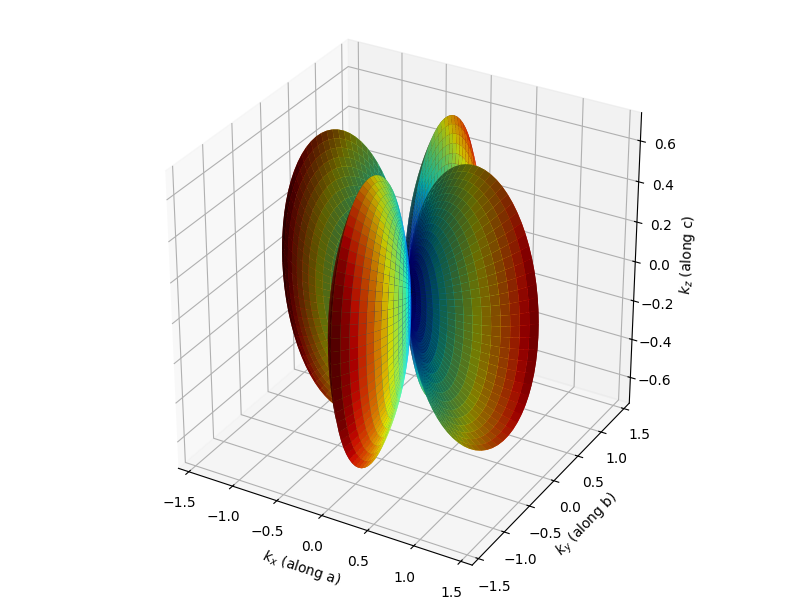

In [151]:
%matplotlib widget
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_deformed, y_deformed, z_deformed,
                facecolors=plt.cm.jet((radius - radius.min()) / np.ptp(radius)),
                rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('$k_x$ (along a)')
ax.set_ylabel('$k_y$ (along b)')
ax.set_zlabel('$k_z$ (along c)')
plt.tight_layout()
plt.show()

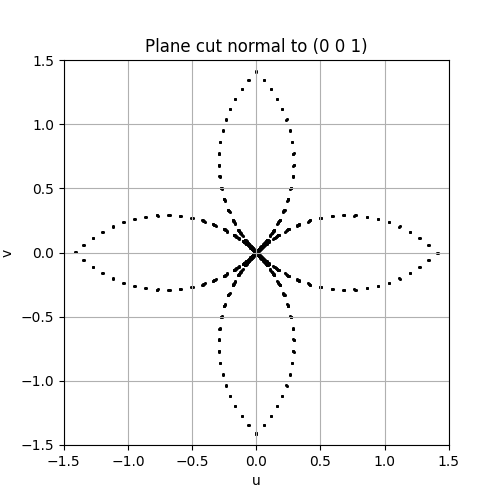

In [156]:
plot_plane_cut(x_deformed,y_deformed,z_deformed,[0,0,1])